Adapted from https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

In [ ]:
# installed in virtualenv
#%pip install -Uqq duckduckgo_search
#%pip install -Uqq fastai

# activate the Python virtual env, run this in a bash terminal
#source ~/.virtualenvs/fast_ai/Scripts/activate

from fastcore.all import *
from duckduckgo_search import DDGS


In [35]:
# get a bird image
image_url = DDGS().images("bird", max_results=1)[0]["image"]
print(image_url)

https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg


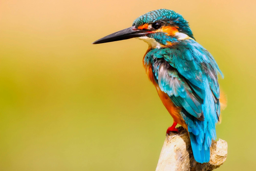

In [36]:
from fastdownload import download_url

dest="bird.jpg"
download_url(image_url, dest, show_progress=False)

from fastai.vision.all import *
image=Image.open(dest)
image.to_thumb(356, 256)

Define a _search_images_ function

"L" is a function in fastcore that creates a more efficient _list_ and provides many functionalities.

In [66]:
def search_images(term, max_images=10):
    print(f'Searcing for "{term}" images')
    results = DDGS().images(term, max_results=max_images)
    return L(results).itemgot("image")

Searcing for "dog" images


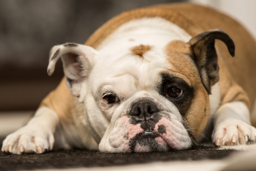

In [67]:
download_url(search_images("dog", max_images=1)[0], "dog.jpg", show_progress=False)
Image.open("dog.jpg").to_thumb(256, 256)


In [252]:
searches = "dog", "cat"
path = Path("images")

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(o, max_images=30))
    sleep(20)
    download_images(dest, urls=search_images(f"{o} on the beach", max_images=20))
    sleep(20)
    download_images(dest, urls=search_images(f"{o} in the sun", max_images=20))
    sleep(20)
    download_images(dest, urls=search_images(f"{o} on the sofa", max_images=20))
    sleep(20)
    download_images(dest, urls=search_images(f"{o} on the carpet", max_images=20))

Searcing for "dog" images
Searcing for "dog on the beach" images
Searcing for "dog in the sun" images
Searcing for "dog on the sofa" images
Searcing for "dog on the carpet" images
Searcing for "cat" images
Searcing for "cat on the beach" images
Searcing for "cat in the sun" images
Searcing for "cat on the sofa" images
Searcing for "cat on the carpet" images


In [254]:
# some could possibly not download correctly, we remove them

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"removed {len(failed)} images")

removed 12 images


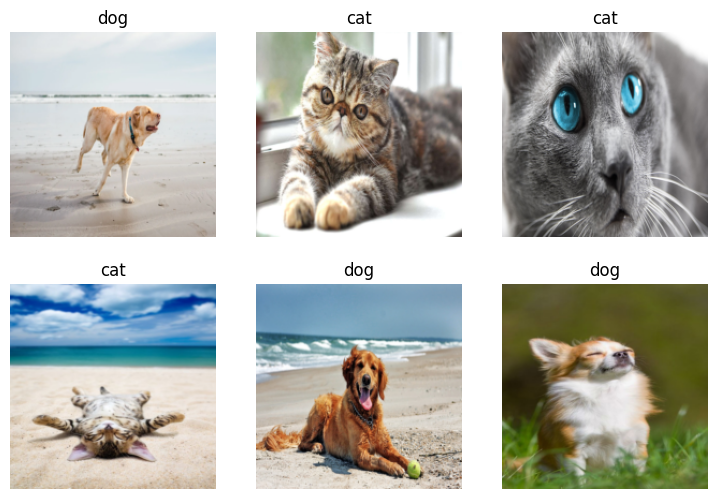

In [255]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # a random 20% of images are used for training
    get_y=parent_label, # get the label from parent folder inpath ("cat", "dog") and use it to create the result categories
    item_tfms=[Resize(192, method="squish")]  # to have the same dimensions  (192x192)
).dataloaders(path)

# dataloader will FEED the algorithm with batches of data

dls.show_batch(max_n=6)  ## see an example of input provided to the AI

DataBlock is container to create DataSet and DataLoaders.  

There are many Blocks: https://docs.fast.ai/data.block.html

https://docs.fast.ai/


In [226]:
learn = vision_learner(dls, resnet18, metrics=error_rate)  # use resnet18 model
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.137020,0.239738,0.109091,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.461326,0.146249,0.054545,00:47
1,0.332456,0.089455,0.018182,00:46
2,0.235004,0.047207,0.000000,00:47
3,0.183926,0.042736,0.000000,00:45


Models are pre-trained models.  
Orther models can be found here: https://timm.fast.ai  

_fine_tune_ will adapt the model (that is trained with its images) to our dataset.



In [256]:
xlearn = vision_learner(dls, xresnet50, metrics=error_rate)  # use xresnet50 model
xlearn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.032063,8.326317,0.515789,02:09


epoch,train_loss,valid_loss,error_rate,time
0,0.703020,2.120728,0.484211,02:42
1,0.532310,0.696574,0.294737,02:38
2,0.435392,0.580256,0.231579,02:38
3,0.378026,0.404879,0.115789,02:42
4,0.324572,0.359364,0.105263,02:41


Searcing for "cat on red sofa in january" images


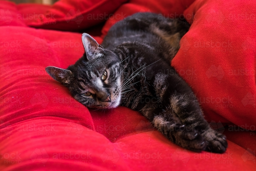

In [261]:
test_image = "test-animal.jpg"
download_url(search_images("cat on red sofa in january", max_images=1)[0], test_image, show_progress=False)
Image.open(test_image).to_thumb(256, 256)


In [262]:
cat_or_dog,_,probs = learn.predict(PILImage.create(test_image))
#print(f'Probability is a dog {probs[0]:.4f}')
print(f'Probability is a cat {probs[0]*100:.2f}%')
print(f'Probability is a dog {probs[1]*100:.2f}%')

print(f"cat_or_dog: {cat_or_dog}")


Probability is a cat 98.68%
Probability is a dog 1.32%
cat_or_dog: cat


In [ ]:
# Save the trained model

